# Project description

**Determining the cost of cars**

The used car sales service "Not damaged, not repainted" is developing an application to attract new customers. The app will allow users to quickly find out the market value of their car. You have historical data at your disposal, including technical specifications, equipment, and prices of cars. Your task is to build a model to determine the cost.

The client's priorities are:

- The quality of the prediction.
- The speed of the prediction.
- The training time.

# Table of contents

---

1. [Data](#data)
    * [Data preprocessing](#data-preprocessing)
    * [Exploratory data analysis](#data-eda)
    * [Conclusion](#data-conclusion)
2. [Model preparation](#model-preparation)
    * [Datasets](#model-datasets-preparation)
    * [Hyperparameter tuning](#model-hyperparameter-tuning)
    * [Conclusion](#model-conclusion)
3. [Model analysis](#model-analysis)
    * [Model training](#model-training)
    * [Test dataset](#model-test)
    * [Final results](#model-final-results)
5. [Conclusion](#conclusion)
---

## Data <a class="anchor" id="data"></a>

In [1]:
%%capture
!pip install catboost

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import seaborn as sns
import warnings
from catboost import CatBoostRegressor, Pool, cv
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [3]:
# Searching for file
file_names = ['autos.csv']
url = 'https://code.s3.yandex.net/datasets/autos.csv'

file_path = None

for root, dirs, files in os.walk('.'):
    for file_name in file_names:
        if file_name in files:
            file_path = os.path.join(root, file_name)
            break
    else:
        continue
    break

if file_path is not None:
    data = pd.read_csv(file_path)
else:
    data = pd.read_csv(url)

# Ignoring all warnings and displaying all columns in the DF
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Basic information
print(f"Shape of dataframe: {data.shape}")
print(f"-" * 26)
print(f"Missing values: \n")
print(data.isnull().sum().sum())
print(f"-" * 26)
print(f"Duplicates: {data.duplicated().sum() / len(data) * 100}%")
print(f"-" * 26)
print(f"Dataframe info: \n")
print(data.info())
print(f"-" * 26)
display(data.head())
print(f"\n")
display(data.describe())
print(f"\n")

Shape of dataframe: (354369, 16)
--------------------------
Missing values: 

181077
--------------------------
Duplicates: 0.0011287669068118262%
--------------------------
Dataframe info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        3

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Data preprocessing <a class="anchor" id="data-preprocessing"></a>

Data exploration revealed a large number of anomalies and missing values. To preserve the original data, we will work with a copy. Here, we will also get rid of unnecessary features for model training. Important features for training include:

- `VehicleType`: the body type affects the price of the car, but within a brand and model, there may be several body types;
- `Brand`, `Model`: it is important to understand which brands and models we are studying (premium, regular, or economy);
- `RegistrationYear`: the age of the car may affect the price, except for retro or exclusive cars;
- `Gearbox`, `Power`, `FuelType`: the technical characteristics of the car determine the price;
- `Kilometer`: the mileage affects the price;
- `Repaired`: whether the car has undergone repairs affects the final price;
- `Price`: target feature.

In [4]:
# Rename `Repaired` column to legacy `NotRepaired`
data = data.rename(columns={'Repaired': 'NotRepaired'})

# Create a copy of DF with selection of features
df = data.loc[:, ['VehicleType',
                  'Brand', 'Model',
                  'RegistrationYear',
                  'Gearbox', 'Power', 'FuelType',
                  'Kilometer', 'NotRepaired', 'Price'
                  ]].copy()
print(df.isna().mean() * 100)
df.head()

VehicleType         10.579368
Brand                0.000000
Model                5.560588
RegistrationYear     0.000000
Gearbox              5.596709
Power                0.000000
FuelType             9.282697
Kilometer            0.000000
NotRepaired         20.079070
Price                0.000000
dtype: float64


,VehicleType,Brand,Model,RegistrationYear,Gearbox,Power,FuelType,Kilometer,NotRepaired,Price
0,NaN,volkswagen,golf,1993,manual,0,petrol,150000,NaN,480
1,coupe,audi,NaN,2011,manual,190,gasoline,125000,yes,18300
2,suv,jeep,grand,2004,auto,163,gasoline,125000,NaN,9800
3,small,volkswagen,golf,2001,manual,75,petrol,150000,no,1500
4,small,skoda,fabia,2008,manual,69,gasoline,90000,no,3600


Removed columns:

In [5]:
cols_difference = data.columns.difference(df.columns)
cols_difference

Index(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures',
       'PostalCode', 'RegistrationMonth'],
      dtype='object')

**Date of downloading the questionnaire from the database**

This information is for reference only and does not require processing.

In [6]:
data['DateCrawled'].value_counts().sort_values(ascending=False)

2016-03-24 14:49:47    7
2016-03-19 21:49:56    6
2016-03-26 22:57:31    6
2016-03-31 16:50:28    5
2016-03-07 17:36:19    5
                      ..
2016-03-22 11:53:58    1
2016-03-30 21:57:23    1
2016-03-23 19:45:34    1
2016-03-05 18:43:29    1
2016-03-19 18:57:12    1
Name: DateCrawled, Length: 271174, dtype: int64

**Price (Euros)**

Let's look at the distribution of prices, excluding zero records.

0       10772
500      5670
1500     5394
1000     4649
1200     4594
2500     4438
600      3819
Name: Price, dtype: int64

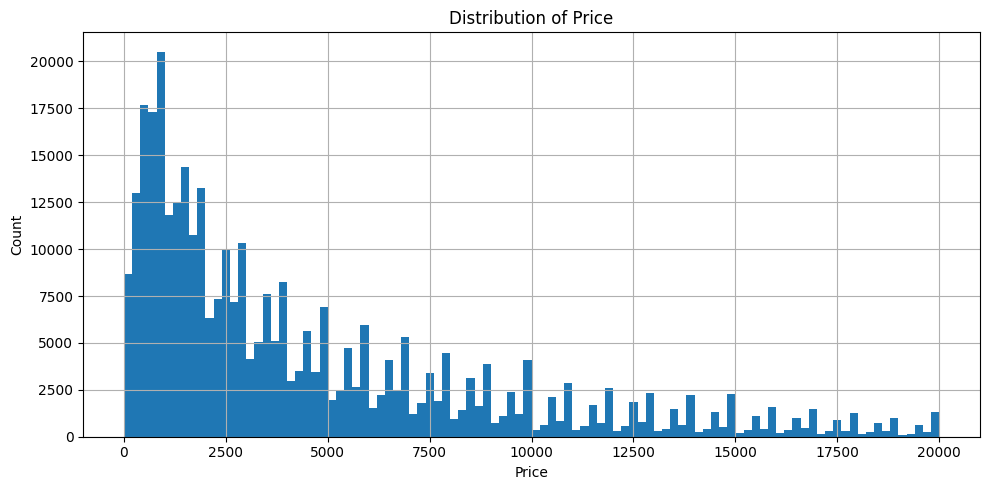

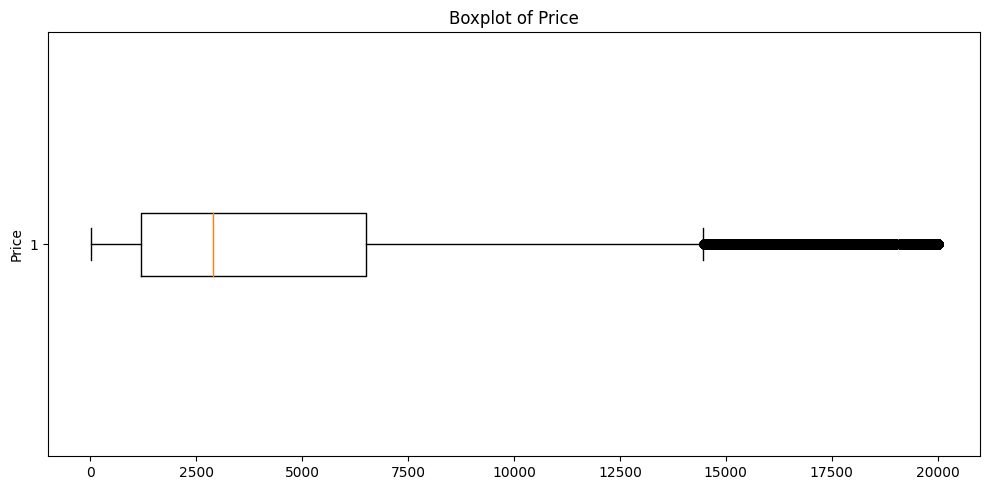

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

In [7]:
# Get the Price column from the DataFrame
df_price = df['Price']

# Display the count of each unique value in Price, sorted by descending count
display(df_price.value_counts().sort_values(ascending=False).head(7))

# Plot a histogram of Price values greater than zero
plt.figure(figsize=(10, 5))
df_price[df_price > 0].hist(bins=100)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Distribution of Price')
plt.tight_layout()
plt.show()

# Create a boxplot of Price values greater than zero
plt.figure(figsize=(10, 5))
plt.boxplot(df_price[df_price > 0], vert=False)
plt.ylabel('Price')
plt.title('Boxplot of Price')
plt.tight_layout()
plt.show()

# Get summary statistics for Price values greater than zero
display(df_price[df_price > 0].describe())

Let's look at the 5% and 90% percentiles.

In [8]:
df_price.quantile([0.05, 0.9])

0.05      200.0
0.90    11450.0
Name: Price, dtype: float64

It is not possible to restore zero values in the car price, so we will have to delete these records. We will also filter by values from the obtained percentiles.

In [9]:
df = df.query('Price >= 200 & Price <= 11500')
print(f"Removed {round((data.shape[0] - df.shape[0]) / data.shape[0] * 100, 2)}% of the data.")

Removed 14.53% of the data.


**Type of car body**

In [10]:
df['VehicleType'].value_counts().sort_values(ascending=False)

sedan          79209
small          73781
wagon          56064
bus            24951
convertible    15881
coupe          12277
suv             7664
other           2807
Name: VehicleType, dtype: int64

Replace NaN with `unknown`, since the body may differ even within the same model. **Justification** on the example of the Volkswagen Passat. This car was presented in different body styles throughout the model's existence: hatchback (small), wagon (estate), coupe (coupe), sedan (sedan), and even a hard-top convertible (convertible) in 2015. Let's take a look at the Alltrack version in the SUV body.

In [11]:
df.loc[
    (df['Brand'] == 'volkswagen') & 
    (df['Model'] =='passat') & 
    (df['VehicleType'] == 'suv')
]

,VehicleType,Brand,Model,RegistrationYear,Gearbox,Power,FuelType,Kilometer,NotRepaired,Price
11394,suv,volkswagen,passat,1998,manual,101,petrol,150000,NaN,1600
90879,suv,volkswagen,passat,1996,manual,0,petrol,150000,no,500
116771,suv,volkswagen,passat,1998,manual,101,petrol,150000,NaN,1500
127182,suv,volkswagen,passat,2008,manual,140,gasoline,150000,no,6950


In [12]:
df['VehicleType'].fillna('unknown', inplace=True)
print(f"Amount of NaN in `VehicleType`: {df['VehicleType'].isna().sum()}")

Amount of NaN in `VehicleType`: 0


**Car brand**

In [13]:
np.sort(df['Brand'].unique())

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

**Car model**

Let's take a closer look at NaN values in this feature.

In [14]:
print(f"Amount of NaN in `Model`: {df['Model'].isna().sum()}")
df[df['Model'].isna()].head()

Amount of NaN in `Model`: 15486


,VehicleType,Brand,Model,RegistrationYear,Gearbox,Power,FuelType,Kilometer,NotRepaired,Price
81,small,fiat,NaN,1997,manual,54,NaN,150000,yes,350
135,sedan,audi,NaN,1992,manual,136,NaN,150000,no,1450
151,small,volkswagen,NaN,2009,NaN,60,petrol,20000,no,6799
160,small,renault,NaN,1999,manual,0,petrol,150000,no,500
161,wagon,volkswagen,NaN,2001,NaN,64,gasoline,150000,NaN,1495


In [15]:
df['Model'].value_counts().sort_values(ascending=False)

golf          25343
other         20611
3er           16882
polo          11841
corsa         11482
              ...  
rangerover        3
amarok            3
q3                2
serie_1           1
serie_3           1
Name: Model, Length: 248, dtype: int64

Replace NaN with `unknown`.

In [16]:
df['Model'].fillna('unknown', inplace=True)
print(f"Amount of NaN in `Model`: {df['Model'].isna().sum()}")

Amount of NaN in `Model`: 0


**Year of car registration**

In [17]:
np.sort(df['RegistrationYear'].unique())

array([1000, 1001, 1039, 1111, 1234, 1300, 1400, 1500, 1600, 1602, 1800,
       1910, 1923, 1925, 1928, 1929, 1930, 1931, 1932, 1934, 1935, 1936,
       1937, 1938, 1941, 1942, 1943, 1944, 1945, 1946, 1948, 1950, 1951,
       1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962,
       1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2066, 2200, 2290, 2500, 2800, 2900, 3000, 3200, 3700,
       3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5900, 5911, 6000,
       7000, 7100, 7800, 8200, 8500, 8888, 9000, 9450, 9999])

Let's look at the chart of registration years according to data on the first car in open sources. According to the condition, we have historical data, including 2016. Therefore, we can safely remove everything newer. We will analyze the lower bound.

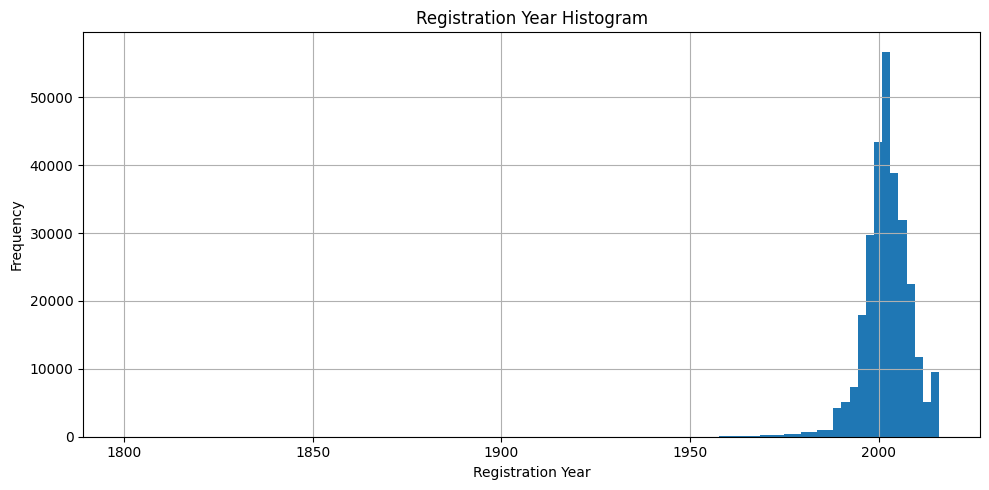

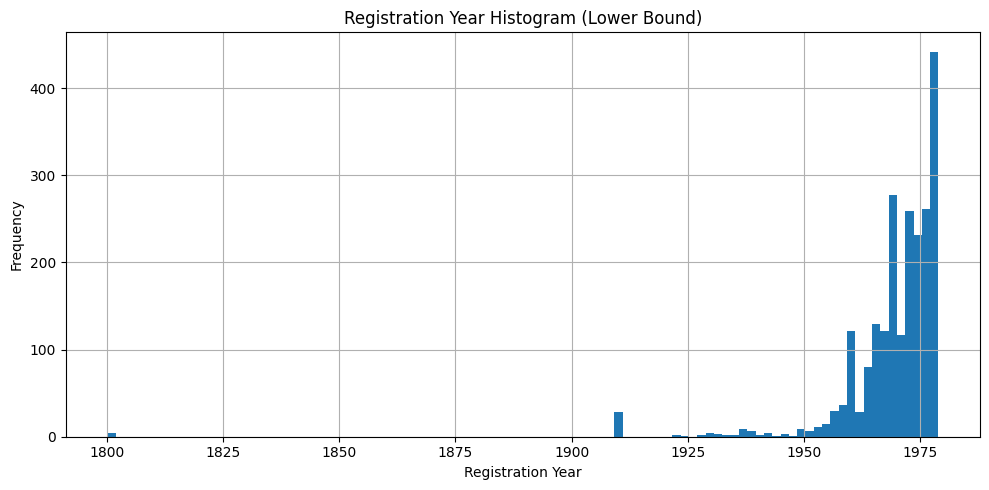

In [18]:
df_reg_year = df['RegistrationYear']
df_reg_year = df_reg_year[df_reg_year <= 2016]
df_reg_year = df_reg_year[df_reg_year >= 1800]
df_reg_year.hist(bins=100, figsize=(10, 5))
plt.title("Registration Year Histogram")
plt.xlabel("Registration Year")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

df_reg_year[df_reg_year < 1980].hist(bins=100, figsize=(10, 5))
plt.title("Registration Year Histogram (Lower Bound)")
plt.xlabel("Registration Year")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


There is a slight "spike" in the period from 1900 to 1925, but it will not affect anything. The growth is noticeable in the period from 1950 to 1975, so we will filter everything from 1950 to 2016 inclusive.

In [19]:
df = df.query('RegistrationYear >= 1950 & RegistrationYear <= 2016')
reg_year_start = np.sort(df['RegistrationYear'].unique()).min()
reg_year_end = np.sort(df['RegistrationYear'].unique()).max()

print(f"Removed {round((data.shape[0] - df.shape[0]) / data.shape[0] * 100, 2)}% of the data.")
print(f"Clean period: {reg_year_start}-{reg_year_end}.")

Removed 18.23% of the data.
Clean period: 1950-2016.


**Type of transmission**

Let's take a closer look at NaN values in this feature.

In [20]:
print(f"Amount of NaN in `Gearbox`: {df['Gearbox'].isna().sum()}")
df[df['Gearbox'].isna()].head()

Amount of NaN in `Gearbox`: 13369


,VehicleType,Brand,Model,RegistrationYear,Gearbox,Power,FuelType,Kilometer,NotRepaired,Price
16,unknown,volkswagen,polo,2016,NaN,60,petrol,150000,NaN,300
32,sedan,volkswagen,golf,1994,NaN,0,petrol,150000,no,245
37,unknown,renault,kangoo,2016,NaN,0,gasoline,150000,no,1500
69,coupe,opel,astra,2001,NaN,0,NaN,150000,NaN,1200
92,unknown,ford,ka,2000,NaN,60,NaN,150000,NaN,250


In [21]:
df['Gearbox'].value_counts().sort_values(ascending=False)

manual    227668
auto       48746
Name: Gearbox, dtype: int64

Electric cars are present in the ads, which do not have a gearbox, but to avoid creating an additional value, let's replace all `electric` with `auto` in `Gearbox`. 

In [22]:
df[df['FuelType'] == 'electric']

,VehicleType,Brand,Model,RegistrationYear,Gearbox,Power,FuelType,Kilometer,NotRepaired,Price
12571,small,renault,other,2014,auto,15,electric,10000,no,5999
13227,small,renault,other,2013,auto,18,electric,10000,no,5799
13316,coupe,mercedes_benz,c_klasse,2001,auto,170,electric,125000,no,4200
16237,other,sonstige_autos,unknown,2006,auto,5,electric,40000,no,4500
25191,other,sonstige_autos,unknown,2010,NaN,0,electric,5000,NaN,2000
...,...,...,...,...,...,...,...,...,...,...
340404,small,daihatsu,cuore,1996,auto,45,electric,50000,yes,1000
343292,small,renault,other,2012,auto,11,electric,50000,no,5250
344961,small,renault,other,2012,auto,13,electric,20000,no,6500
348891,small,renault,other,2014,auto,18,electric,10000,no,5690


In [23]:
df.loc[(df['Gearbox'].isnull()) & (df['FuelType'] == 'electric')]

,VehicleType,Brand,Model,RegistrationYear,Gearbox,Power,FuelType,Kilometer,NotRepaired,Price
25191,other,sonstige_autos,unknown,2010,NaN,0,electric,5000,NaN,2000
66254,small,sonstige_autos,unknown,2010,NaN,14,electric,10000,no,6600
67587,small,sonstige_autos,unknown,1993,NaN,0,electric,150000,NaN,550
83642,small,renault,other,2012,NaN,11,electric,20000,no,4950
91391,convertible,sonstige_autos,unknown,2007,NaN,0,electric,30000,no,3500
110222,small,renault,other,2012,NaN,11,electric,20000,no,5390
110822,small,smart,fortwo,2013,NaN,75,electric,40000,no,8400
147119,small,renault,other,2013,NaN,11,electric,20000,no,6499
151821,unknown,sonstige_autos,unknown,2007,NaN,0,electric,30000,yes,3500


In [24]:
df['Gearbox'] = np.where((df['Gearbox'].isnull()) & (df['FuelType'] == 'electric'), 'auto', 'auto')
df[df['FuelType'] == 'electric'].head()

,VehicleType,Brand,Model,RegistrationYear,Gearbox,Power,FuelType,Kilometer,NotRepaired,Price
12571,small,renault,other,2014,auto,15,electric,10000,no,5999
13227,small,renault,other,2013,auto,18,electric,10000,no,5799
13316,coupe,mercedes_benz,c_klasse,2001,auto,170,electric,125000,no,4200
16237,other,sonstige_autos,unknown,2006,auto,5,electric,40000,no,4500
25191,other,sonstige_autos,unknown,2010,auto,0,electric,5000,NaN,2000


I assume that in other cases, the gearbox type is not specified because it is mechanical by default, i.e. `manual`. This can support the replacement of gaps with `manual`.

In [25]:
df['Gearbox'].fillna('manual', inplace=True)
print(f"Amount of NaN in `Gearbox`: {df['Gearbox'].isna().sum()}")

Amount of NaN in `Gearbox`: 0


**Horsepower**

In [26]:
np.sort(df['Power'].unique())

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

A randomly chosen number (650) from the above array showed the manufacturer "sonstige_autos". Unfortunately, Google does not provide anything specific: these can be trailers, spare parts, or even a manufacturer of car models on a scale. It is not possible to restore power and other indicators.

In [27]:
df[df['Power'] == 650]

,VehicleType,Brand,Model,RegistrationYear,Gearbox,Power,FuelType,Kilometer,NotRepaired,Price
212083,other,sonstige_autos,unknown,1999,auto,650,petrol,150000,no,4900
353633,sedan,citroen,c2,2007,auto,650,petrol,150000,NaN,2400


In [28]:
df[df['Brand'] == 'sonstige_autos'].head(5)

,VehicleType,Brand,Model,RegistrationYear,Gearbox,Power,FuelType,Kilometer,NotRepaired,Price
306,unknown,sonstige_autos,unknown,2009,auto,0,NaN,10000,NaN,200
431,small,sonstige_autos,unknown,2004,auto,5,gasoline,70000,no,3950
661,suv,sonstige_autos,unknown,2000,auto,250,lpg,150000,no,9900
700,sedan,sonstige_autos,unknown,2010,auto,186,petrol,125000,no,6999
985,sedan,sonstige_autos,unknown,2010,auto,101,petrol,70000,yes,500


Let's look at the distribution and remove inflated and extremely low values in the data based on the diagram.

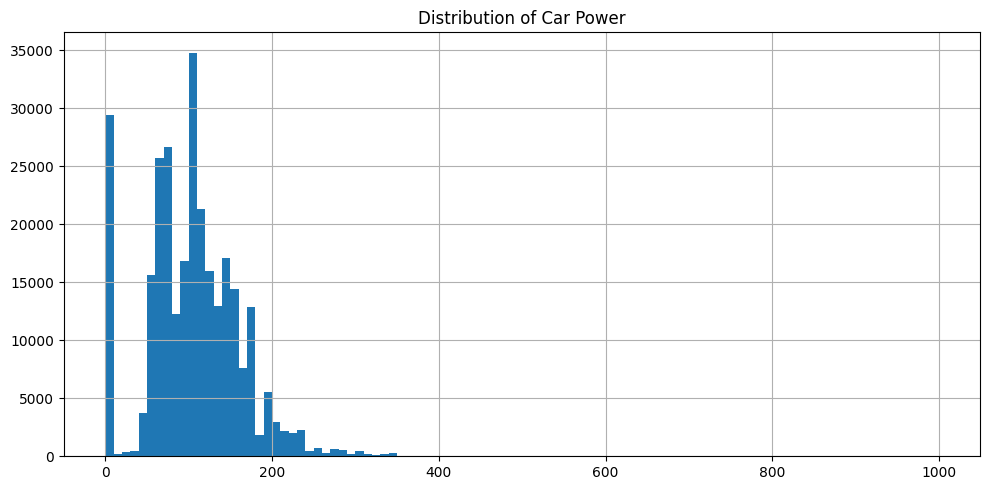

count    289533.000000
mean        102.868592
std          58.004761
min           0.000000
25%          69.000000
50%         102.000000
75%         140.000000
max         999.000000
Name: Power, dtype: float64

In [29]:
df_power = df['Power']
df_power[df_power < 1000].hist(bins=100, figsize=(10, 5))
plt.title('Distribution of Car Power')
plt.tight_layout()
plt.show()

df_power[df_power < 1000].describe()

In [30]:
df = df.query('Power > 15 & Power <= 400')

print(f"Removed {round((data.shape[0] - df.shape[0]) / data.shape[0] * 100, 2)}% of the data.")

Removed 26.66% of the data.


**Fuel type**

In [31]:
df['FuelType'].value_counts().sort_values(ascending=False)

petrol      169892
gasoline     70721
lpg           4430
cng            464
hybrid         112
other           79
electric        27
Name: FuelType, dtype: int64

Here, as in the body type, there can be both diesel/gasoline engines and hybrid, electric, or even gas (lpg, cng).

In [32]:
df['FuelType'].fillna('unknown', inplace=True)
print(f"Amount of NaN in `FuelType`: {df['FuelType'].isna().sum()}")

Amount of NaN in `FuelType`: 0


**Mileage (km)**

In [33]:
np.sort(df['Kilometer'].unique())

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000])

**Record of car repair**

Let's take a closer look at NaN values in this feature.

In [34]:
print(f"Amount of NaN in `NotRepaired`: {df['NotRepaired'].isna().sum()}")
df[df['NotRepaired'].isna()].head()

Amount of NaN in `NotRepaired`: 39514


,VehicleType,Brand,Model,RegistrationYear,Gearbox,Power,FuelType,Kilometer,NotRepaired,Price
2,suv,jeep,grand,2004,auto,163,gasoline,125000,NaN,9800
9,small,volkswagen,golf,1998,auto,101,unknown,150000,NaN,999
12,wagon,volkswagen,passat,1995,auto,115,petrol,150000,NaN,999
16,unknown,volkswagen,polo,2016,auto,60,petrol,150000,NaN,300
31,unknown,renault,clio,2016,auto,60,petrol,150000,NaN,899


Replace NaN's. **Justification:** if it is not indicated that the car was repaired, then there can be no other option. The exception may be intentional concealment of information.

In [35]:
df['NotRepaired'].fillna('yes', inplace=True)
print(f"Amount of NaN in `NotRepaired`: {df['NotRepaired'].isna().sum()}")
df['NotRepaired'].value_counts()

Amount of NaN in `NotRepaired`: 0


no     193575
yes     66335
Name: NotRepaired, dtype: int64

After data preprocessing, we have:

In [36]:
print(f"-" * 26)
print(f"Removed {round((data.shape[0] - df.shape[0]) / data.shape[0] * 100, 2)}% of the data.")
print(f"-" * 26)
print(f"Missing values: \n")
print(df.isna().mean() * 100)
print(f"-" * 26)
df.head()

--------------------------
Removed 26.66% of the data.
--------------------------
Missing values: 

VehicleType         0.0
Brand               0.0
Model               0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
FuelType            0.0
Kilometer           0.0
NotRepaired         0.0
Price               0.0
dtype: float64
--------------------------


,VehicleType,Brand,Model,RegistrationYear,Gearbox,Power,FuelType,Kilometer,NotRepaired,Price
2,suv,jeep,grand,2004,auto,163,gasoline,125000,yes,9800
3,small,volkswagen,golf,2001,auto,75,petrol,150000,no,1500
4,small,skoda,fabia,2008,auto,69,gasoline,90000,no,3600
5,sedan,bmw,3er,1995,auto,102,petrol,150000,yes,650
6,convertible,peugeot,2_reihe,2004,auto,109,petrol,150000,no,2200


### Exploratory data analysis <a class="anchor" id="data-eda"></a>

Let's look at the correlation of the data:

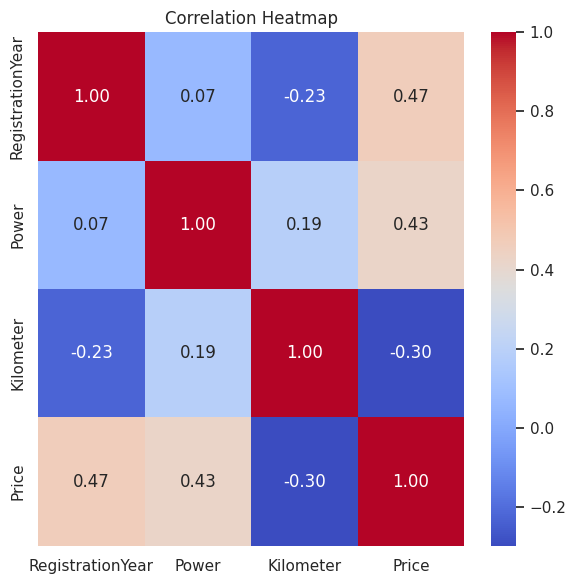

In [37]:
# Seaborn style
sns.set(
    style='white',
    palette='colorblind',
    rc={'figure.figsize': (6, 6)},
    color_codes=True)

# Plotting the heatmap with title
plt.title('Correlation Heatmap')
sns.heatmap(df.corr(), cmap='coolwarm', cbar=True, annot=True, fmt='.2f')
plt.tight_layout()
plt.show()

In [38]:
df.describe()

,RegistrationYear,Power,Kilometer,Price
count,259910.000000,259910.000000,259910.000000,259910.000000
mean,2002.200350,114.253034,132023.758224,3643.481197
std,6.093528,47.716190,33496.310965,2924.322593
min,1950.000000,16.000000,5000.000000,200.000000
25%,1999.000000,75.000000,125000.000000,1250.000000
50%,2002.000000,105.000000,150000.000000,2750.000000
75%,2006.000000,140.000000,150000.000000,5500.000000
max,2016.000000,400.000000,150000.000000,11500.000000


### Conclusion <a class="anchor" id="data-conclusion"></a>

1. Missing values were observed in the following features:
    - `Model`: 5.56%
    - `Gearbox`: 5.59%
    - `FuelType`: 9.28%
    - `VehicleType`: 10.57%
    - `NotRepaired`: 20.07%
2. The **target feature** `Price` contains many zero values - 10,772;
3. The `RegistrationYear` feature contains many erroneous records (e.g. year 1234 or 9000);
4. The `Power` feature includes extremely high engine power values;
5. The `Kilometer` feature seems to have dummy mileage records.
6. In the `Gearbox` feature, NaN values for electric cars in the `FuelType` column can be replaced with `auto`;
7. Unnecessary features for model training were identified.

8. Analysis of missing values and their replacement:
    - `Price`: 14.53% of the original dataframe was removed by filtering with the 5% and 90% quantiles;
    - `VehicleType`: NaN was replaced with unknown, as the body type may differ even within the same model;
    - `Model`: NaN was replaced with unknown;
    - `RegistrationYear`: 18.23% of the original data was removed by defining a "clean" period from 1950 to 2016;
    - `Gearbox`: for all electric cars with NaN, it was replaced with auto (67 ads), and the remaining missing values were replaced with manual;
    - `Power`: 26.66% of the original data was removed by filtering out abnormally high and low values;
    - `FuelType`: NaN was replaced with unknown, as different engines can be present within the same model;
    - `NotRepaired`: all NaN were replaced with yes, assuming that we have honest ads and not scams.
9. Cleaning the dataframe from unnecessary data:
    - `DateCrawled`;
    - `DateCreated`;
    - `LastSeen`;
    - `NumberOfPictures`;
    - `PostalCode`;
    - `RegistrationMonth`.
10. Exploratory data analysis:
    - The price has a correlation with the registration date of the car `r=0.47` and its power `r=0.43`.

## Model preparation <a class="anchor" id="model-preparation"></a>

### Datasets preparation <a class="anchor" id="model-datasets-preparation"></a>

We will prepare three types of datasets: with original data, transformed by one-hot encoding (OHE), and transformed by ordinal encoding (OE).

In [39]:
# Original feature and target
features = df.drop('Price', axis=1)
target = df['Price']

# OHE
features_ohe = pd.get_dummies(features, drop_first=True)

# OE
encoder = OrdinalEncoder()
columns_oe = list(df.select_dtypes(include='object').columns)
columns_oe = ['VehicleType', 'Brand', 'Model', 'Gearbox', 'FuelType', 'NotRepaired']

features_oe = features[columns_oe]
features_oe = pd.DataFrame(
    encoder.fit_transform(features_oe),
    columns=features_oe.columns,
    index=features_oe.index
)

In [40]:
# Datasets split
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=8080)

X_ohe_train = features_ohe.loc[X_train.index, :]
X_ohe_test = features_ohe.loc[X_test.index, :]

X_oe_train = features_oe.loc[X_train.index, :]
X_oe_test = features_oe.loc[X_test.index, :]

# Print proportions of each set
x, x_ = features.shape
a, a_ = X_train.shape
b, b_ = X_test.shape

def perc(pt, whl):
    perc = 100 * pt / whl
    return str(round(perc)) + '%'

print(f"Original data: {x}")
print(f"Train dataset: {perc(a, x)}")
print(f"Test dataset: {perc(b, x)}")


Original data: 259910
Train dataset: 75%
Test dataset: 25%


In [41]:
scaler = StandardScaler()

# Scaling the OHE features
numeric = X_ohe_train.columns
scaler.fit(X_ohe_train)

X_ohe_train_scaled = scaler.transform(X_ohe_train)
X_ohe_test_scaled = scaler.transform(X_ohe_test)

# Scaling the OE features
numeric = X_oe_train.columns
scaler.fit(X_oe_train)

X_oe_train_scaled = scaler.transform(X_oe_train)
X_oe_test_scaled = scaler.transform(X_oe_test)

### Hyperparameter tuning <a class="anchor" id="model-hyperparameter-tuning"></a>

The following models will be used:
1. DecisionTreeRegressor
2. LinearRegression
3. CatBoostRegressor
4. LGBMRegressor

In [42]:
state = np.random.RandomState(8080)

In [43]:
# Passing hyperparameters to GridSearch:
def grid_search(clf_name):
    params = {'DecisionTreeRegressor'   : {'max_depth'        : range(10, 30, 2),
                                           'max_features'     : ['auto'],
                                           'min_samples_leaf' : range(1, 8, 1),
                                           'criterion'        : ['squared_error']},
             'CatBoostRegressor'        : {'depth'            : [2, 16, 32],
                                           'learning_rate'    : [0.8],
                                           'iterations'       : [60]},
             'LGBMRegressor'            : {'max_depth'        : range(1, 20, 5),
                                           'num_leaves'       : range(10, 100, 10),
                                           'learning_rate'    : [0.8]}
             }
    return params[clf_name]

**DecisionTreeRegressor**

Using DecisionTreeRegressor on the OHE dataset is not expedient and will not be used.

In [44]:
%%time

# DecisionTreeRegressor (Ordinal Enconding)
model_dtr = DecisionTreeRegressor(random_state=8080)
grid_dtr_oe = GridSearchCV(
    model_dtr,
    grid_search(clf_name=type(model_dtr).__name__),
    scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=10
)
grid_dtr_oe.fit(X_oe_train_scaled, y_train)

means = grid_dtr_oe.cv_results_['mean_test_score']
rmse_model_dtr_oe = (max(means)*-1) ** 0.5
rmse_model_dtr_oe = round(rmse_model_dtr_oe, 2)

print(f"\nBest parameters for {type(model_dtr).__name__} with OE dataset: {grid_dtr_oe.best_params_}")
print(f"RMSE: {rmse_model_dtr_oe}\n")

Fitting 5 folds for each of 70 candidates, totalling 350 fits

Best parameters for DecisionTreeRegressor with OE dataset: {'criterion': 'squared_error', 'max_depth': 22, 'max_features': 'auto', 'min_samples_leaf': 4}
RMSE: 2318.4

CPU times: user 2.14 s, sys: 741 ms, total: 2.89 s
Wall time: 1min 5s


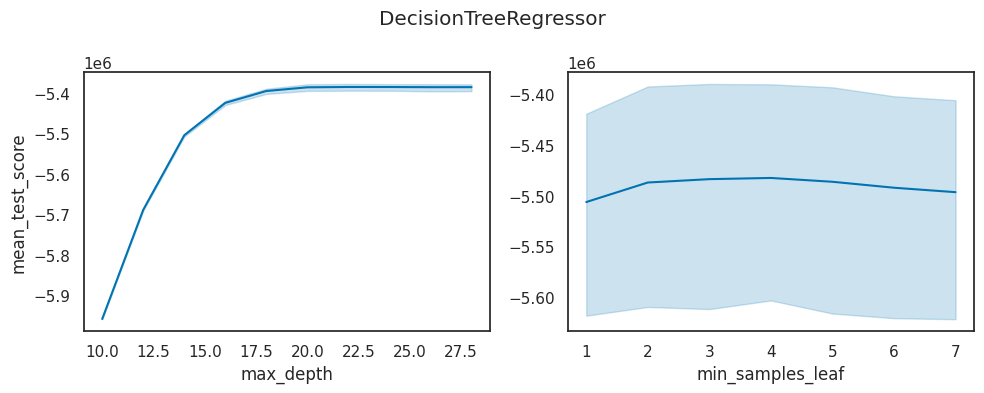

In [45]:
# Define the subplots
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

# Decision Tree Regressor
sns.lineplot(x='param_max_depth', y='mean_test_score', data=pd.DataFrame(grid_dtr_oe.cv_results_), ax=axs[0])
sns.lineplot(x='param_min_samples_leaf', y='mean_test_score', data=pd.DataFrame(grid_dtr_oe.cv_results_), ax=axs[1])

# Add title and labels to the subplots
fig.suptitle('DecisionTreeRegressor')
axs[0].set(xlabel='max_depth', ylabel='mean_test_score')
axs[1].set(xlabel='min_samples_leaf', ylabel='')

# Adjust the layout and spacing of the subplots
plt.tight_layout()

**LinearRegression**

In [46]:
%%time

model_lr = LinearRegression()

# Linear Regression (One-Hot Encoding)
model_lr.fit(X_ohe_train_scaled, y_train)
predictions_ohe = model_lr.predict(X_ohe_train_scaled)
rmse_lr_ohe = mean_squared_error(y_train, predictions_ohe, squared=False)
rmse_lr_ohe = round(rmse_lr_ohe, 2)

print(f"RMSE for {type(model_lr).__name__} with OHE dataset: {rmse_lr_ohe}\n")

RMSE for LinearRegression with OHE dataset: 1770.53

CPU times: user 13 s, sys: 3.25 s, total: 16.3 s
Wall time: 13.7 s


In [47]:
%%time

# Linear Regression (Ordinal Enconding)
model_lr.fit(X_oe_train_scaled, y_train)
predictions_oe = model_lr.predict(X_oe_train_scaled)
rmse_lr_oe = mean_squared_error(y_train, predictions_oe, squared=False)
rmse_lr_oe = round(rmse_lr_oe, 2)

print(f"RMSE for {type(model_lr).__name__} with OE dataset: {rmse_lr_oe}\n")

RMSE for LinearRegression with OE dataset: 2689.8

CPU times: user 74.4 ms, sys: 69.7 ms, total: 144 ms
Wall time: 76.7 ms


**CatBoostRegressor**

In [48]:
%%time

model_cbr = CatBoostRegressor()

# CatBoostRegressor (One-Hot Encoding)
grid_cbr_ohe = GridSearchCV(
    model_cbr,
    grid_search(clf_name=type(model_cbr).__name__),
    scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=False
)
grid_cbr_ohe.fit(X_ohe_train, y_train)

means = grid_cbr_ohe.cv_results_['mean_test_score']
rmse_model_cbr_ohe = (max(means)*-1) ** 0.5
rmse_model_cbr_ohe = round(rmse_model_cbr_ohe, 2)

print(f"\nBest parameters for {type(model_cbr).__name__} with OHE dataset: {grid_cbr_ohe.best_params_}")
print(f"RMSE: {rmse_model_cbr_ohe}\n")

0:	learn: 1618.3330299	total: 1.18s	remaining: 1m 9s
1:	learn: 1351.1383727	total: 2.24s	remaining: 1m 4s
2:	learn: 1299.7046624	total: 3.27s	remaining: 1m 2s
3:	learn: 1271.4582537	total: 4.3s	remaining: 1m
4:	learn: 1252.7168978	total: 5.33s	remaining: 58.6s
5:	learn: 1239.2477113	total: 6.46s	remaining: 58.2s
6:	learn: 1223.2361530	total: 8.29s	remaining: 1m 2s
7:	learn: 1211.6193797	total: 9.79s	remaining: 1m 3s
8:	learn: 1201.6185079	total: 10.8s	remaining: 1m 1s
9:	learn: 1194.3901147	total: 11.8s	remaining: 59.3s
10:	learn: 1186.6324908	total: 12.9s	remaining: 57.4s
11:	learn: 1176.3003824	total: 13.9s	remaining: 55.6s
12:	learn: 1167.0366329	total: 14.9s	remaining: 54s
13:	learn: 1162.4986896	total: 16s	remaining: 52.4s
14:	learn: 1155.8091044	total: 17s	remaining: 50.9s
15:	learn: 1151.7269762	total: 18s	remaining: 49.5s
16:	learn: 1145.9532517	total: 19.1s	remaining: 48.2s
17:	learn: 1136.3157900	total: 20.4s	remaining: 47.7s
18:	learn: 1132.4001307	total: 22.3s	remaining: 48

In [49]:
%%time

# CatBoostRegressor (Ordinal Enconding)
grid_cbr_oe = GridSearchCV(
    model_cbr,
    grid_search(clf_name=type(model_cbr).__name__),
    scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=1
)
grid_cbr_oe.fit(X_oe_train, y_train)

means = grid_cbr_oe.cv_results_['mean_test_score']
rmse_model_cbr_oe = (max(means)*-1) ** 0.5
rmse_model_cbr_oe = round(rmse_model_cbr_oe, 2)

print(f"\nBest parameters for {type(model_cbr).__name__} with OE dataset: {grid_cbr_oe.best_params_}")
print(f"RMSE: {rmse_model_cbr_oe}\n")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
0:	learn: 2515.6564928	total: 566ms	remaining: 33.4s
1:	learn: 2448.3317981	total: 1.18s	remaining: 34.1s
2:	learn: 2414.4579458	total: 1.73s	remaining: 32.8s
3:	learn: 2392.8947033	total: 2.35s	remaining: 33s
4:	learn: 2374.1467637	total: 3.19s	remaining: 35.1s
5:	learn: 2354.6314995	total: 4.05s	remaining: 36.5s
6:	learn: 2342.7372949	total: 4.94s	remaining: 37.4s
7:	learn: 2332.8533582	total: 5.5s	remaining: 35.8s
8:	learn: 2324.5488004	total: 6.05s	remaining: 34.3s
9:	learn: 2319.8158673	total: 6.59s	remaining: 33s
10:	learn: 2318.6893034	total: 6.62s	remaining: 29.5s
11:	learn: 2318.0054987	total: 6.66s	remaining: 26.6s
12:	learn: 2314.6718879	total: 7.21s	remaining: 26.1s
13:	learn: 2311.7092541	total: 7.75s	remaining: 25.5s
14:	learn: 2307.8374776	total: 8.29s	remaining: 24.9s
15:	learn: 2305.0517694	total: 8.84s	remaining: 24.3s
16:	learn: 2302.6102540	total: 9.39s	remaining: 23.7s
17:	learn: 2299.5196803	total: 9.94s	

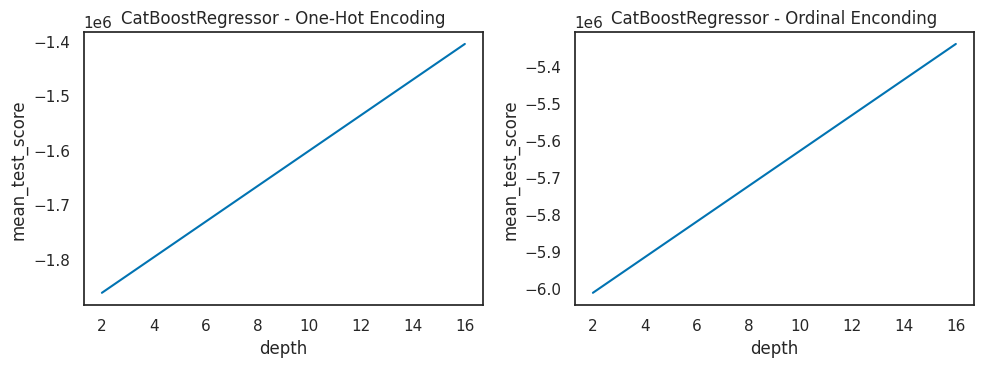

In [50]:
# CatBoostRegressor hyperparameters plots
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

sns.lineplot(x='param_depth', y='mean_test_score', data=pd.DataFrame(grid_cbr_ohe.cv_results_), ax=axs[0])
sns.lineplot(x='param_depth', y='mean_test_score', data=pd.DataFrame(grid_cbr_oe.cv_results_), ax=axs[1])
axs[0].set(title='CatBoostRegressor - One-Hot Encoding', xlabel='depth', ylabel='mean_test_score')
axs[1].set(title='CatBoostRegressor - Ordinal Enconding', xlabel='depth', ylabel='mean_test_score')
plt.tight_layout()

**LGBMRegressor**

In [51]:
%%time

model_lgbmr = LGBMRegressor()

# LGBMRegressor (One-Hot Encoding)
grid_lgbmr_ohe = GridSearchCV(
    model_lgbmr,
    grid_search(clf_name=type(model_lgbmr).__name__),
    scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=10
)
grid_lgbmr_ohe.fit(X_ohe_train, y_train)

means = grid_lgbmr_ohe.cv_results_['mean_test_score']
rmse_model_lgbmr_ohe = (max(means)*-1) ** 0.5
rmse_model_lgbmr_ohe = round(rmse_model_lgbmr_ohe, 2)

print(f"\nBest parameters for {type(model_lgbmr).__name__} with OHE dataset: {grid_lgbmr_ohe.best_params_}")
print(f"RMSE: {rmse_model_lgbmr_ohe}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters for LGBMRegressor with OHE dataset: {'learning_rate': 0.8, 'max_depth': 11, 'num_leaves': 40}
RMSE: 1191.21
CPU times: user 7.57 s, sys: 867 ms, total: 8.44 s
Wall time: 7min 30s


In [52]:
%%time

# LGBMRegressor (Ordinal Encoding)
grid_lgbmr_oe = GridSearchCV(
    model_lgbmr,
    grid_search(clf_name=type(model_lgbmr).__name__),
    scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=10
)
grid_lgbmr_oe.fit(X_oe_train, y_train)
decision_tree_params = grid_lgbmr_oe.best_params_

means = grid_lgbmr_oe.cv_results_['mean_test_score']
rmse_model_lgbmr_oe = (max(means)*-1) ** 0.5
rmse_model_lgbmr_oe = round(rmse_model_lgbmr_oe, 2)

print(f"\nBest parameters for {type(model_lgbmr).__name__} with OE dataset: {grid_lgbmr_oe.best_params_}")
print(f"RMSE: {rmse_model_lgbmr_oe}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters for LGBMRegressor with OE dataset: {'learning_rate': 0.8, 'max_depth': 11, 'num_leaves': 50}
RMSE: 2306.42
CPU times: user 5.3 s, sys: 351 ms, total: 5.65 s
Wall time: 2min 22s


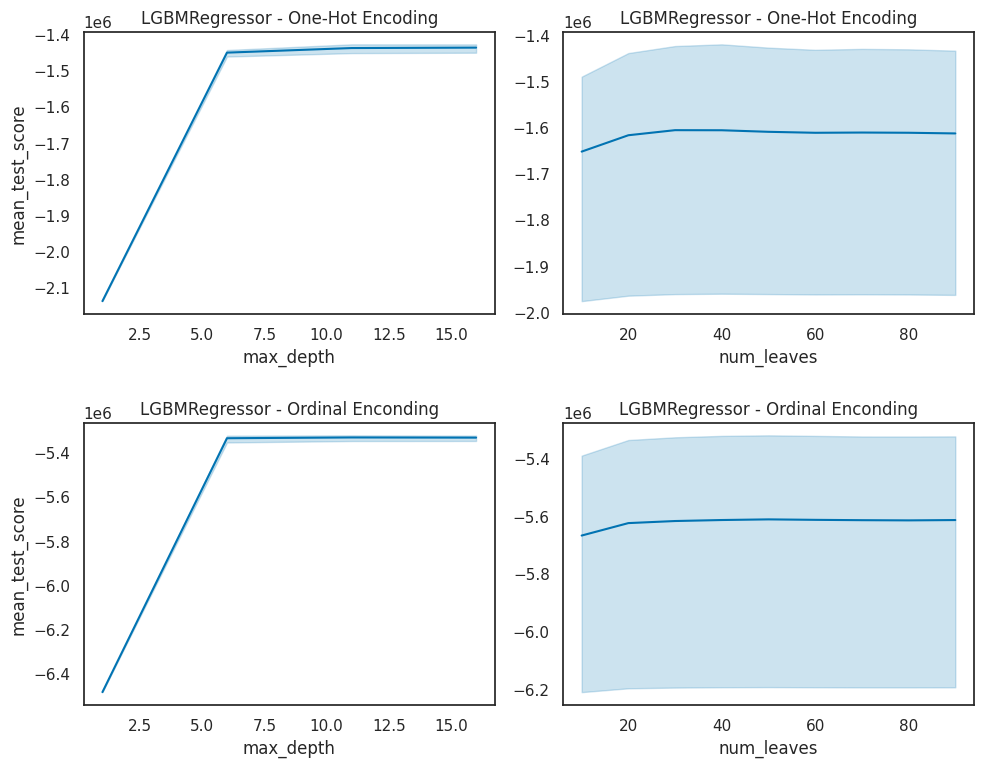

In [53]:
# LGBMRegressor hyperparameters plots
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))

sns.lineplot(x='param_max_depth', y='mean_test_score', data=pd.DataFrame(grid_lgbmr_ohe.cv_results_), ax=axs[0,0])
sns.lineplot(x='param_num_leaves', y='mean_test_score', data=pd.DataFrame(grid_lgbmr_ohe.cv_results_), ax=axs[0,1])
sns.lineplot(x='param_max_depth', y='mean_test_score', data=pd.DataFrame(grid_lgbmr_oe.cv_results_), ax=axs[1,0])
sns.lineplot(x='param_num_leaves', y='mean_test_score', data=pd.DataFrame(grid_lgbmr_oe.cv_results_), ax=axs[1,1])
axs[0,0].set(title='LGBMRegressor - One-Hot Encoding', xlabel='max_depth', ylabel='mean_test_score')
axs[0,1].set(title='LGBMRegressor - One-Hot Encoding', xlabel='num_leaves', ylabel='')
axs[1,0].set(title='LGBMRegressor - Ordinal Enconding', xlabel='max_depth', ylabel='mean_test_score')
axs[1,1].set(title='LGBMRegressor - Ordinal Enconding', xlabel='num_leaves', ylabel='')
plt.tight_layout()

### Conclusion <a class="anchor" id="model-conclusion"></a>

For each model, we obtained the RMSE value when tuning the parameters on OHE and OE samples, let's take a look at them along with the best parameters found by `GridSearchCV`:

In [54]:
rmse_vals = {'DTR_OE'   : rmse_model_dtr_oe,
             'LR_OHE'   : rmse_lr_ohe,
             'LR_OE'    : rmse_lr_oe,
             'CBR_OHE'  : rmse_model_cbr_ohe,
             'CBR_OE'   : rmse_model_cbr_oe,
             'LGBMR_OHE': rmse_model_lgbmr_ohe,
             'LGBMR_OE' : rmse_model_lgbmr_oe
}
rmse_subtotals = pd.DataFrame(rmse_vals, index=[1])
rmse_subtotals

,DTR_OE,LR_OHE,LR_OE,CBR_OHE,CBR_OE,LGBMR_OHE,LGBMR_OE
1,2318.4,1770.53,2689.8,1185.3,2310.92,1191.21,2306.42


In [55]:
# Best hyperparameters
params_vals = {'DTR_OE'     : grid_dtr_oe.best_params_,
               'CBR_OHE'    : grid_cbr_ohe.best_params_,
               'CBR_OE'     : grid_cbr_oe.best_params_,
               'LGBMR_OHE'  : grid_lgbmr_ohe.best_params_,
               'LGBMR_OE'   : grid_lgbmr_oe.best_params_
}
params_df = pd.DataFrame(params_vals)
params_df.fillna('', inplace=True)
params_df

,DTR_OE,CBR_OHE,CBR_OE,LGBMR_OHE,LGBMR_OE
criterion,squared_error,,,,
max_depth,22,,,11.0,11.0
max_features,auto,,,,
min_samples_leaf,4,,,,
depth,,16.0,16.0,,
iterations,,60.0,60.0,,
learning_rate,,0.8,0.8,0.8,0.8
num_leaves,,,,40.0,50.0


## Model analysis <a class="anchor" id="model-analysis"></a>

### Model training <a class="anchor" id="model-training"></a>

Based on the obtained results, we will use the best hyperparameters for the selected models and conduct an experiment with training on the test set. The metric used will be RMSE. We will measure the execution time in seconds using a separate variable instead of the _magic_ command `%%time`, for subsequent addition to the table.

In [56]:
# For greater clarity, all the tuned hyperparameters will be added to variables
# DTR_OE:
dtr_oe_criterion = params_df.iloc[0, 0]
dtr_oe_max_depth = params_df.iloc[1, 0]
dtr_oe_max_features = params_df.iloc[2, 0]
dtr_oe_min_samples_leaf = params_df.iloc[3, 0]

# CBR_OHE:
cbr_ohe_depth = params_df.iloc[4, 1]
cbr_ohe_iterations = params_df.iloc[5, 1]
cbr_ohe_learn_rate = params_df.iloc[6, 1]
# CBR_OE:
cbr_oe_depth = params_df.iloc[4, 2]
cbr_oe_iterations = params_df.iloc[5, 2]
cbr_oe_learn_rate = params_df.iloc[6, 2]

# LGBMR_OHE:
lgbmr_ohe_max_depth = int(params_df.iloc[1, 3])
lgbmr_ohe_learning_rate = params_df.iloc[6, 3]
lgbmr_ohe_num_leaves = int(params_df.iloc[7, 3])
# LGBMR_OE:
lgbmr_oe_max_depth = int(params_df.iloc[1, 4])
lgbmr_oe_learning_rate = params_df.iloc[6, 4]
lgbmr_oe_num_leaves = int(params_df.iloc[7, 4])

**DecisionTreeRegressor**

In [57]:
start = time.time()

model_dtr_final = DecisionTreeRegressor(max_depth=dtr_oe_max_depth,
                                        max_features=dtr_oe_max_features,
                                        min_samples_leaf=dtr_oe_min_samples_leaf,
                                        criterion=dtr_oe_criterion,
                                        random_state=8080
                                       )
model_dtr_final.fit(features_ohe, target)
predictions = model_dtr_final.predict(features_ohe)
model_dtr_final_rmse = mean_squared_error(target, predictions) ** 0.5
model_dtr_final_rmse = round(model_dtr_final_rmse, 2)

end = time.time()
run_time_dtr = end - start
run_time_dtr = round(run_time_dtr, 2)

print(f"Model: {type(model_dtr_final).__name__}")
print(f"RMSE: {model_dtr_final_rmse}")
print(f"Completion time: {run_time_dtr} seconds")

Model: DecisionTreeRegressor
RMSE: 1016.85
Completion time: 8.98 seconds


**LinearRegression**

In [58]:
start = time.time()

model_lr_final = LinearRegression()
model_lr_final.fit(features_ohe, target)
predictions = model_lr_final.predict(features_ohe)
model_lr_final_rmse = mean_squared_error(target, predictions) ** 0.5
model_lr_final_rmse = round(model_lr_final_rmse, 2)

end = time.time()
run_time_lr = end - start
run_time_lr = round(run_time_lr, 2)

print(f"Model: {type(model_lr_final).__name__}")
print(f"RMSE: {model_lr_final_rmse}")
print(f"Completion time: {run_time_lr} seconds")

Model: LinearRegression
RMSE: 1770.98
Completion time: 16.01 seconds


**CatBoostRegressor**

In [59]:
start = time.time()

model_cbr_final = CatBoostRegressor(depth=cbr_ohe_depth,
                                    iterations=cbr_ohe_iterations,
                                    learning_rate=cbr_ohe_learn_rate,
                                    verbose=False
                                   )
model_cbr_final.fit(features_ohe, target)
predictions = model_cbr_final.predict(features_ohe)
model_cbr_final_rmse = mean_squared_error(target, predictions) ** 0.5
model_cbr_final_rmse = round(model_cbr_final_rmse, 2)

end = time.time()
run_time_cbr = end - start
run_time_cbr = round(run_time_cbr, 2)

print(f"Model: {type(model_cbr_final).__name__}")
print(f"RMSE: {model_cbr_final_rmse}")
print(f"Completion time: {run_time_cbr} seconds")

Model: CatBoostRegressor
RMSE: 1020.85
Completion time: 73.79 seconds


**LGBMRegressor**

In [60]:
start = time.time()

model_lgbmr_final = LGBMRegressor(learning_rate=lgbmr_ohe_learning_rate,
                                  max_depth=lgbmr_ohe_max_depth,
                                  num_leaves=lgbmr_ohe_num_leaves
                                 )
model_lgbmr_final.fit(features_ohe, target)
predictions = model_lgbmr_final.predict(features_ohe)
model_lgbmr_final_rmse = mean_squared_error(target, predictions) ** 0.5
model_lgbmr_final_rmse = round(model_lgbmr_final_rmse, 2)

end = time.time()
run_time_lgbmr = end - start
run_time_lgbmr = round(run_time_lgbmr, 2)

print(f"Model: {type(model_lgbmr_final).__name__}")
print(f"RMSE: {model_lgbmr_final_rmse}")
print(f"Completion time: {run_time_lgbmr} seconds")

Model: LGBMRegressor
RMSE: 1107.74
Completion time: 7.84 seconds


### Test dataset <a class="anchor" id="model-test"></a>

Let's conduct testing of the trained models on the dataset encoded using `One-Hot Encoding` method:

**DecisionTreeRegressor**

In [61]:
start = time.time()

model_dtr_test = DecisionTreeRegressor(max_depth=dtr_oe_max_depth,
                                       max_features=dtr_oe_max_features,
                                       min_samples_leaf=dtr_oe_min_samples_leaf,
                                       criterion=dtr_oe_criterion,
                                       random_state=8080
                                      )
model_dtr_test.fit(X_ohe_test, y_test)
predictions = model_dtr_test.predict(X_ohe_test)
model_dtr_test_rmse = mean_squared_error(y_test, predictions) ** 0.5
model_dtr_test_rmse = round(model_dtr_test_rmse, 2)

end = time.time()
run_time_dtr_test = end - start
run_time_dtr_test = round(run_time_dtr_test, 2)

print(f"Model: {type(model_dtr_test).__name__}")
print(f"RMSE: {model_dtr_test_rmse}")
print(f"Completion time: {run_time_dtr_test} seconds")

Model: DecisionTreeRegressor
RMSE: 1013.67
Completion time: 1.62 seconds


**LinearRegression**

In [62]:
start = time.time()

model_lr_test = LinearRegression()
model_lr_test.fit(X_ohe_test, y_test)
predictions = model_lr_test.predict(X_ohe_test)
model_lr_test_rmse = mean_squared_error(y_test, predictions) ** 0.5
model_lr_test_rmse = round(model_lr_test_rmse, 2)

end = time.time()
run_time_lr_test = end - start
run_time_lr_test = round(run_time_lr_test, 2)

print(f"Model: {type(model_lr_test).__name__}")
print(f"RMSE: {model_lr_test_rmse}")
print(f"Completion time: {run_time_lr_test} seconds")

Model: LinearRegression
RMSE: 1767.3
Completion time: 2.46 seconds


**CatBoostRegressor**

In [63]:
start = time.time()

model_cbr_test = CatBoostRegressor(depth=cbr_ohe_depth,
                                   iterations=cbr_ohe_iterations,
                                   learning_rate=cbr_ohe_learn_rate,
                                   verbose=False
                                  )
model_cbr_test.fit(X_ohe_test, y_test)
predictions = model_cbr_test.predict(X_ohe_test)
model_cbr_test_rmse = mean_squared_error(y_test, predictions) ** 0.5
model_cbr_test_rmse = round(model_cbr_test_rmse, 2)

end = time.time()
run_time_cbr_test = end - start
run_time_cbr_test = round(run_time_cbr_test, 2)

print(f"Model: {type(model_cbr_test).__name__}")
print(f"RMSE: {model_cbr_test_rmse}")
print(f"Completion time: {run_time_cbr_test} seconds")

Model: CatBoostRegressor
RMSE: 928.4
Completion time: 64.19 seconds


**LGBMRegressor**

In [64]:
start = time.time()

model_lgbmr_test = LGBMRegressor(learning_rate=lgbmr_ohe_learning_rate,
                                 max_depth=lgbmr_ohe_max_depth,
                                 num_leaves=lgbmr_ohe_num_leaves
                                )
model_lgbmr_test.fit(X_ohe_test, y_test)
predictions = model_lgbmr_test.predict(X_ohe_test)
model_lgbmr_test_rmse = mean_squared_error(y_test, predictions) ** 0.5
model_lgbmr_test_rmse = round(model_lgbmr_test_rmse, 2)

end = time.time()
run_time_lgbmr_test = end - start
run_time_lgbmr_test = round(run_time_lgbmr_test, 2)

print(f"Model: {type(model_lgbmr_test).__name__}")
print(f"RMSE: {model_lgbmr_test_rmse}")
print(f"Completion time: {run_time_lgbmr_test} seconds")

Model: LGBMRegressor
RMSE: 1045.59
Completion time: 1.35 seconds


### Final results <a class="anchor" id="model-final-results"></a>

Let's gather all the obtained data in DF.

In [65]:
final_data = {'RMSE (train features)' : [model_dtr_final_rmse, model_lr_final_rmse,
                                         model_cbr_final_rmse, model_lgbmr_final_rmse],
              'RMSE (test features)'  : [model_dtr_test_rmse, model_lr_test_rmse,
                                         model_cbr_test_rmse, model_lgbmr_test_rmse],
              'Time (train features)' : [run_time_dtr, run_time_lr,
                                         run_time_cbr, run_time_lgbmr],
              'Time (test features)'  : [run_time_dtr_test, run_time_lr_test,
                                         run_time_cbr_test, run_time_lgbmr_test]
             }
indexes = [type(model_dtr).__name__, type(model_lr).__name__,
           type(model_cbr).__name__, type(model_lgbmr).__name__]
final = pd.DataFrame(data=final_data, index=indexes)

# Add the ratio column to the final dataframe
final['Ratio'] = round((
    final['Time (train features)'] + final['Time (test features)']
    ) / (
        final['RMSE (train features)'] + final['RMSE (test features)']), 4)

final

,RMSE (train features),RMSE (test features),Time (train features),Time (test features),Ratio
DecisionTreeRegressor,1016.85,1013.67,8.98,1.62,0.0052
LinearRegression,1770.98,1767.30,16.01,2.46,0.0052
CatBoostRegressor,1020.85,928.40,73.79,64.19,0.0708
LGBMRegressor,1107.74,1045.59,7.84,1.35,0.0043


## Conclusion <a class="anchor" id="conclusion"></a>

During the study, we conducted the following:

1. Analyzed and replaced missing values in features, thus reducing the data by 26.66%.
    - Filtered out reasonable prices by using 5% and 90% quantiles.
    - Defined a relevant period of car registration: 1950-2016.
    - Kept only the ads with correct technical characteristics (transmission, engine power, fuel type) based on the analysis results.
2. Cleaned the dataframe from unnecessary data.
3. Found a correlation between the price and the date of car registration and its power with coefficients `r=0.47` and `r=0.43`, respectively.
4. Prepared datasets for analysis with a 75% training set and a 25% test set.
5. Chose four training models: `DecisionTreeRegressor`, `LinearRegression`, `CatBoostRegressor`, and `LGBMRegressor`.
6. Tuned the optimal parameters for them using `GridSearchCV`.
7. Determined the `RMSE` metric on datasets encoded using `One-Hot` and `Ordinal Encoding` methods.
8. Trained models with the best parameters on `train` and `test` datasets encoded using the OHE method. At this stage, the execution time of the cell (model training speed) was also obtained.
9. Compiled a final table with stats of models and selected the **best model** (in the cell below).

In [66]:
lower_rmse_model = final.sort_values(by='RMSE (test features)').index[0]
print(f"Model with lower RMSE: {lower_rmse_model}")
fastest_model = final.sort_values(by='Time (test features)').index[0]
print(f"Fastest model: {fastest_model}")
best_model = final.sort_values(by='Ratio').index[0]
print(f"Best overall model: {best_model}")

Model with lower RMSE: CatBoostRegressor
Fastest model: LGBMRegressor
Best overall model: LGBMRegressor
